# Software Agents coursework

### Import libraries

In [46]:
%matplotlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

#plt.style.use('ggplot')


Using matplotlib backend: TkAgg


### Set-up R Matrix

In [89]:
# set grid size
grid_length = 12 
grid_height = 4

R_matrix = np.full((grid_height, grid_length),-1) # every other step receives -1 reward
R_matrix[-1, 1:grid_length-1] = -100 # cliff 
R_matrix[-1, -1] = 100 #objective
R_matrix

array([[  -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
          -1],
       [  -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
          -1],
       [  -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
          -1],
       [  -1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         100]])

## Set-up Cliff environment
#### Set function for renderer

In [48]:
#for the renderer
def change_range(values, vmin=0, vmax=1):
    start_zero = values - np.min(values)
    return (start_zero / (np.max(start_zero) + 1e-7)) * (vmax - vmin) + vmin

In [97]:
class CliffEnvironment:
    #change these colors
    terrain_color = dict(normal=[127/360, 0, 96/100],
                         objective=[26/360, 100/100, 100/100],
                         cliff=[247/360, 92/100, 70/100],
                         player=[344/360, 93/100, 100/100])
    
    
    def __init__(self):
        self.player = None
        self._create_grid()  
        self._draw_grid()
        
    def _create_grid(self, initial_grid=None):
        self.grid = self.terrain_color['normal'] * np.ones((grid_height, grid_length, 3))
        self._set_terrain(self.grid)
        
    def _set_terrain(self, grid):
        grid[-1, 1:grid_length-1] = self.terrain_color['cliff']
        #grid[-2, 3:9] = self.terrain_color['cliff']
        #grid[0:2, 5:6] = self.terrain_color['cliff']
        grid[-1, -1] = self.terrain_color['objective']
        
    def _draw_grid(self):
        self.fig, self.ax = plt.subplots(figsize=(grid_length, grid_height))
        self.ax.grid(which='minor')       
        self.q_texts = [self.ax.text(*self._id_to_position(i)[::-1], '0',
                                     fontsize=11, verticalalignment='center', 
                                     horizontalalignment='center') for i in range(grid_length * grid_height)]     
         
        self.im = self.ax.imshow(hsv_to_rgb(self.grid), cmap='terrain',
                                 interpolation='nearest', vmin=0, vmax=1)        
        self.ax.set_xticks(np.arange(grid_length))
        self.ax.set_xticks(np.arange(grid_length) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(grid_height))
        self.ax.set_yticks(np.arange(grid_height) - 0.5, minor=True)
        
    def reset(self):
        
        self.player = (grid_height-1, 0) # (y_coord, x,_coord, tuple to indicate current location )       
        return self._position_to_id(self.player)
    
    def step(self, action):
        # SETTING GRID MOVEMENT RULES AND CONSTRAINTS 
        #move UP
        # if action is move UP and the Y_cord is > 0 (i.e. agent is not in the top row of grid)
        if action == 0 and self.player[0] > 0:
            #move the agent one cell up
            self.player = (self.player[0] - 1, self.player[1])
        
        #move DOWN
        # if action is move DOWN and the Y_cord is < last row (i.e. agent is not in the bottom row of grid)
        if action == 1 and self.player[0] < grid_height-1:
            #move the agent one cell down
            self.player = (self.player[0] + 1, self.player[1])
        
        #move RIGHT
        # if action is move RIGHT and the X_cord is < last col (i.e. agent is not in the...
        # furthest right hand column of grid)
        if action == 2 and self.player[1] < grid_length-1:
            #move the agent one cell to the right 
            self.player = (self.player[0], self.player[1] + 1)
        
        #move LEFT
        # if action is move LEFT and the X_cord is > first col (i.e. agent is not in the...
        # furthest left hand column of grid)
        if action == 3 and self.player[1] > 0:
            #move the agent one cell to the left 
            self.player = (self.player[0], self.player[1] - 1)
        
        #Assign reward for chosen action
        #reward = R_matrix[self.player[1],self.player[1]]
        
        #
        if all(self.grid[self.player] == self.terrain_color['cliff']) or all(self.grid[self.player] == self.terrain_color['objective']):
            reward = R_matrix[self.player[0],self.player[1]]
            terminal_state = True
        else:
            reward = R_matrix[self.player[0],self.player[1]]
            terminal_state = False
            
        return self._position_to_id(self.player), reward, terminal_state

    
    def _position_to_id(self, pos):
        ''' Maps a position in x,y coordinates to a unique ID '''
        return pos[0] * 12 + pos[1]
    
    def _id_to_position(self, idx):
        return (idx // 12), (idx % 12)
        
    def render(self, Q_matrix=None, action=None, max_q=False, colorize_q=False):
        assert self.player is not None, 'You first need to call .reset()'  
        
        if colorize_q:
            assert Q_matrix is not None, 'Q_matrix must not be None for using colorize_q'            
            grid = self.terrain_color['normal'] * np.ones((grid_height, grid_length, 3))
            values = change_range(np.max(Q_matrix, -1)).reshape(grid_height, grid_length)
            grid[:, :, 1] = values
            self._set_terrain(grid)
        else:            
            grid = self.grid.copy()
            
        grid[self.player] = self.terrain_color['player']       
        self.im.set_data(hsv_to_rgb(grid))
               
        if Q_matrix is not None:
            xs = np.repeat(np.arange(grid_length), grid_height)
            ys = np.tile(np.arange(grid_height), grid_length)  
            
            for i, text in enumerate(self.q_texts):
                if max_q:
                    q = max(Q_matrix[i])    
                    txt = '{:.2f}'.format(q)
                    text.set_text(txt)
                else:                
                    actions = ['U', 'D', 'R', 'L']
                    txt = '\n'.join(['{}: {:.2f}'.format(k, q) for k, q in zip(actions, Q_matrix[i])])
                    text.set_text(txt)
                
        if action is not None:
            self.ax.set_title(action, color='r', weight='bold', fontsize=32)

        plt.pause(0.01)


### Initialise parameteres and environment

In [98]:
UP = 0
DOWN = 1
RIGHT = 2
LEFT = 3
actions = ['UP', 'DOWN', 'RIGHT', 'LEFT']

In [99]:
# The number of states in simply the number of "squares" in our grid world, in this case 4 * 12
num_states = grid_length * grid_height
# We have 4 possible actions, up, down, right and left
num_actions = 4

#Initialise the Q-matrix with an array of zeros. 
Q_matrix = np.zeros((num_states, num_actions))

df = pd.DataFrame(Q_matrix, columns=['A0: up', 'A1: down', 'A2: right', 'A3: left'])
df.index.name = 'States'
df.head(5)

,A0: up,A1: down,A2: right,A3: left
States,,,,
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


## Define an initial e-greedy policy

In [101]:
def egreedy_policy(Q_matrix, state, epsilon=0.9):
    ''' 
    Choose an action based on a epsilon greedy policy.    
    A random action is selected with epsilon probability, else select the best action.    
    '''
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        return np.argmax(Q_matrix[state])

#### Define our traditional q-learning algorithm (Watkins & Dayan, 2002)

In [201]:
def q_learning(cliff, num_episodes=5000, render=False, decay = True, epsilon = 0.9,
               epsilon_threshold = 0.75, alpha_lr =0.1, gamma=0.9):    
    
    #Initialise Q(s,a) matrix 
    Q_matrix = np.zeros((num_states, num_actions))
    rewards_list = []
    max_reward = 100-grid_length 
    first_max_threshold = 0 
    episodes_to_max = 99999
    
    
    for episode in range(num_episodes):
        
        state = cliff.reset() #initialise state St
        terminal_state = False
        reward_sum = 0

        while not terminal_state:            
            # Choose action (At) from state (St) using egreedy_policy       
            action = egreedy_policy(Q_matrix, state, epsilon)
                       
            # Execute the action (At) to the environment 
            #and observe new state (s at t+1)
            
            next_state, reward, terminal_state = cliff.step(action)
            #Receive immediate reward (r at t+1)
            reward_sum += reward
            
            # Update Q_matrix using Watkins and Dayan 1992 update rule
            td_target = reward + gamma * np.max(Q_matrix[next_state])
            td_error = td_target - Q_matrix[state][action]
            Q_matrix[state][action] += alpha_lr * td_error
            state = next_state
            
            if decay: 
                if epsilon >= epsilon_threshold: 
                    epsilon =  0.999 * epsilon
                else: 
                    epsilon =  0.9999 * epsilon            

            if render:
                cliff.render(Q_matrix, action=actions[action], colorize_q=True)
            
        rewards_list.append(reward_sum)
        
        if first_max_threshold < 1 and reward_sum == 88:
            print('Found optimal path after only: {} episodes'.format(episode))
            episodes_to_max = episode
            first_max_threshold += 1
        
        if episode % 1000 == 0: 
            print('Episode: {} completed'.format(episode))
    
    return rewards_list, Q_matrix, episodes_to_max


#### Define the SA_Q_Learning algorithm (Guo et al 2004)

In [158]:
def sa_q_learning(cliff, num_episodes=5000, render=False, decay = True, epsilon = 0.9, 
                  epsilon_threshold = 0.5, alpha_lr =0.1, gamma=0.9):    
    '''
    from Guo et al 2004, based on the Metropolis criterion
    
    
    
    '''
    #Initialise Q(s,a) matrix 
    Q_matrix = np.zeros((num_states, num_actions))
    rewards_list = []
    max_reward = 100-grid_length 
    first_max_threshold = 0 
    episodes_to_max = 99999
    
    
    for episode in range(num_episodes):
        
        state = cliff.reset() #initialise state St
        terminal_state = False
        reward_sum = 0

        while not terminal_state:            
            # Choose action (At) from state (St) using egreedy_policy       
            action_policy = egreedy_policy(Q_matrix, state, epsilon)
            
            #select an action arbitrarily
            action_r = np.random.choice(4)
            
            #extract the Q values for both the policy action and the 
            # arbitrary action_r
            Q_p = Q_matrix[state][action_policy]
            Q_r = Q_matrix[state][action_r]
            
            #generate a random value ξ∈(0,1) 
            ξ = np.random.random()
           
            if ξ < np.exp((Q_r - Q_p)/epsilon):
                # Execute the action (At) to the environment 
                #and observe new state (s at t+1)
                next_state, reward, terminal_state = cliff.step(action_r)
                #Receive immediate reward (r at t+1)
                reward_sum += reward

                # Update Q_matrix using Watkins and Dayan 1992 update rule
                td_target = reward + gamma * np.max(Q_matrix[next_state])
                td_error = td_target - Q_matrix[state][action_r]
                Q_matrix[state][action_r] += alpha_lr * td_error
                
            else: 
                next_state, reward, terminal_state = cliff.step(action_policy)
                
                #Receive immediate reward (r at t+1)
                reward_sum += reward

                # Update Q_matrix using Watkins and Dayan 1992 update rule
                td_target = reward + gamma * np.max(Q_matrix[next_state])
                td_error = td_target - Q_matrix[state][action_policy]
                Q_matrix[state][action_policy] += alpha_lr * td_error
            
            state = next_state
            
            if decay: 
                if epsilon >= epsilon_threshold: 
                    epsilon =  0.999 * epsilon
                else: 
                    epsilon =  0.9999 * epsilon

            if render:
                cliff.render(Q_matrix, action=actions[action], colorize_q=True)
            
        rewards_list.append(reward_sum)
        
        if first_max_threshold < 1 and reward_sum == 88:
            print('Found optimal path after only: {} episodes'.format(episode))
            episodes_to_max = episode
            first_max_threshold += 1
        
        if episode % 1000 == 0: 
            print('Episode: {} completed'.format(episode))
    
    return rewards_list, Q_matrix, episodes_to_max


#### Define the Backwards Q-learning based Sarsa algorithm BQSA (Hao Wang et al, 2013)

In [308]:
def bqsa_learning(cliff, num_episodes=5000, render=False, decay = True, epsilon = 0.9, 
                  epsilon_threshold = 0.75, alpha_lr =0.1, gamma=0.9):    
    '''
    Backward Q based SARSA algorithm 
    from Hao Wang et al 2013, 
    
    '''
    
    #Initialise Q(s,a) matrix 
    Q_matrix = np.zeros((num_states, num_actions))
    rewards_list = []
    max_reward = 100-grid_length 
    first_max_threshold = 0 
    episodes_to_max = 99999
    
    for episode in range(num_episodes):
        
        state = cliff.reset() #initialise state St
        
        # Choose action (At) from state (St) using egreedy_policy       
        action = egreedy_policy(Q_matrix, state, epsilon)
        
        terminal_state = False
        reward_sum = 0
        
        M = []
        N = 0

        while not terminal_state:  

            # Execute the action (At) to the environment 
            #and observe new state (s at t+1)
            next_state, reward, terminal_state = cliff.step(action)

            #Receive immediate reward (r at t+1)
            reward_sum += reward
            
            # Choose next action
            next_action = egreedy_policy(Q_matrix, next_state, epsilon)
            # Next q value is the value of the next action
            
            M_i = {"i": N, 
                "st": state, 
                "at": action, 
                "rt+1": reward,
                "st+1": next_state}
            
            M.append(M_i)
            
            # Next q value is the value of the next action
            #td_target = reward + gamma * np.max(Q_matrix[next_state][action])
            #td_error = td_target - Q_matrix[state][action]
            update = alpha_lr * (reward + (gamma * Q_matrix[next_state][next_action]) - Q_matrix[state][action])
            # Update q value
            Q_matrix[state][action] += update
            
           

            # Update state and action        
            state = next_state
            action = next_action
            
            if decay: 
                if epsilon >= epsilon_threshold: 
                    epsilon =  0.999 * epsilon
                else: 
                    epsilon =  0.9999 * epsilon            

            if render:
                cliff.render(Q_matrix, action=actions[action], colorize_q=True)
                
            N += 1
            
        rewards_list.append(reward_sum)
        
        for x in reversed(range(N)):
            update = alpha_lr * (reward + (gamma * np.max(Q_matrix[M[x]["st+1"]][M[x]["at"]])) - Q_matrix[M[x]["st"]][M[x]["at"]]) 
            Q_matrix[M[x]["st"]][M[x]["at"]] = Q_matrix[M[x]["st"]][M[x]["at"]]  + update  
            
            
        
        if first_max_threshold < 1 and reward_sum == 88:
            print('Found optimal path after only: {} episodes'.format(episode))
            episodes_to_max = episode
            first_max_threshold += 1
        
        if episode % 1000 == 0: 
            print('Episode: {} completed'.format(episode))
            
        if decay: 
                if epsilon >= epsilon_threshold: 
                    epsilon =  0.999 * epsilon
                else: 
                    epsilon =  0.9999 * epsilon
    
    return rewards_list, Q_matrix, episodes_to_max, M



In [309]:
a, b, c, M = bqsa_learning(cliff)

Episode: 0 completed
Episode: 1000 completed
Episode: 2000 completed
Episode: 3000 completed
Episode: 4000 completed


In [310]:
M

[{'i': 0, 'st': 36, 'at': 0, 'rt+1': -1, 'st+1': 24},
 {'i': 1, 'st': 24, 'at': 0, 'rt+1': -1, 'st+1': 12},
 {'i': 2, 'st': 12, 'at': 2, 'rt+1': -1, 'st+1': 13},
 {'i': 3, 'st': 13, 'at': 2, 'rt+1': -1, 'st+1': 14},
 {'i': 4, 'st': 14, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 5, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 6, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 7, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 8, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 9, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 10, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 11, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 12, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 13, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 14, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 15, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 16, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 17, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1': 2},
 {'i': 18, 'st': 2, 'at': 0, 'rt+1': -1, 'st+1'

In [218]:
#M = []
M_i = {"i": 10, 
                "st": 20, 
                "at": 30, 
                "rt+1": 40 ,
                "st+1": 50}

M.append(M_i)

M[i]

TypeError: list indices must be integers or slices, not float

In [238]:
lis= [] 
for x in range(len(M)): 
    temp = M[x]
    temp2 = temp['i']
    lis.append(temp2)

lis.reverse()
print(lis)

[10, 10, 10, 10, 10, 1]


In [180]:
def adaptive_q_learning(cliff, decay = True, num_episodes=5000, render=False, epsilon = 0.9,
               alpha_lr =0.1, gamma=0.9):    
    '''
    Based on Hwang et al (2004)
    
    
    '''
    
    #Initialise Q(s,a) matrix 
    Q_matrix = np.zeros((num_states, num_actions))
    rewards_list = []
    max_reward = 100-grid_length 
    first_max_threshold = 0 
    episodes_to_max = 99999
    TH_P = 800 
    TH_N = -600 
    C = 100
    β = 2
    k = 1.15 
    
    
    
    
    for episode in range(num_episodes):
        
        state = cliff.reset() #initialise state (St)
        terminal_state = False
        reward_sum = 0
        
        
        #for each step in the episode
        while not terminal_state:            
            # Choose action (At) from state (St) using egreedy_policy       
            action = egreedy_policy(Q_matrix, state, epsilon)
            # Execute the action (At) to the environment 
            #and observe new state (s at t+1)
            
            next_state, reward, terminal_state = cliff.step(action)
            
            
            #Receive immediate reward (r at t+1)
            reward_sum += reward
            
            # Update Q_matrix using Watkins and Dayan 1992 update rule
            td_target = reward + gamma * np.max(Q_matrix[next_state])
            td_error = td_target - Q_matrix[state][action]
            Q_matrix[state][action] += alpha_lr * td_error
            state = next_state
            
            if decay: 
                if epsilon >= 0.4: 
                    epsilon =  0.999 * epsilon
                else: 
                    epsilon =  0.9999 * epsilon            

            if render:
                cliff.render(Q_matrix, action=actions[action], colorize_q=True)
            
        rewards_list.append(reward_sum)
        
        if first_max_threshold < 1 and reward_sum == 88:
            print('Found optimal path after only: {} episodes'.format(episode))
            episodes_to_max = episode
            first_max_threshold += 1
        
        if episode % 1000 == 0: 
            print('Episode: {} completed'.format(episode))
    
    return rewards_list, Q_matrix, episodes_to_max


In [123]:
def sarsa(cliff, num_episodes=10, render=False, epsilon = 0.1,
               alpha_lr =0.5, gamma=0.9): 
    
    
#  Initialize arbitrarily all Q(S,A) values
    Q_matrix = np.zeros((num_states, num_actions))
    rewards_list = []
    max_reward = 100-grid_length 
    first_max_threshold = 0 
    episodes_to_max = 99999    
    
    for episode in range(num_episodes):
        state = cliff.reset()    
        terminal_state = False
        reward_sum = 0
        action = egreedy_policy(Q_matrix, state, epsilon)


        while not terminal_state:        
            # Do the action
            next_state, reward, done = env.step(action)
            reward_sum += reward
            
            # Choose next action
            next_action = egreedy_policy(Q_matrix, next_state, epsilon)
            # Next q value is the value of the next action
            td_target = reward + gamma * Q_matrix[next_state][next_action]
            td_error = td_target - Q_matrix[state][action]
            # Update q value
            Q_matrix[state][action] += alpha_lr * td_error

            # Update state and action        
            state = next_state
            action = next_action
            
        if render:
            env.render(Q_matrix, action=actions[action], colorize_q=True)
                
    
    results_list.append(reward_sum)

        
    return results_list, Q_matrix
            
            
            

#  Repeat (for each episode):
        #Choose a random state st or initialize state st
#  Choose an action at from state st using the policy derived from Q (use Boltzmann Distribution)
#  Repeat (for each step in the episode)
#    Execute the select action at to the environment, then receive immediate reward rt+1 and observe the new state st+1
#    Choose an action at+1 from state st+1 using policy derived from Q (use Boltzmann Distribution)
#    Update Q(st,at) according to Eq. (3)
#    st←st+1; at←at+1
#  Until st is terminal
#  Recalculate the temperature parameter using the temperature-dropping criterion
#  Until the desired number of episodes has been searched

#### Define a parse_results_list() utility function to be called within the run_Q main function


In [272]:
%matplotlib inline     

def parse_results_list(results_list): 
    
    
    # from list of dicts to PD dataframe
    parsed_results_df = pd.DataFrame(results_list, index=None)
    
    #print top 5 by episodes to optimal solution
    print("Top 5 results, by episodes to find optimal path: \n", 
          parsed_results_df.sort_values('Epi_to_max', ascending = True).head())
    
    #print top 5 by mean reward over 5000 episodes 
    print("\n \n Top 5 results, by mean reward over 5000 episodes: \n",
          parsed_results_df.sort_values('Mean reward', ascending = False).head())

    #filter out experiments that did not find optimal path
    completed_parsed_results_df = parsed_results_df[parsed_results_df['Epi_to_max'] < 999]
    
    #plot results
    
    if len(completed_parsed_results_df) != 0:
        completed_parsed_results_df.plot.scatter(x='Epi_to_max', y='Mean reward')
        return parsed_results_df
    else:
         print("No experiments in this batch made it to the end of the game .")
    
    



## Q-LEARNING: grid-search to find optimal parameters. 

Episode: 0 completed
Found optimal path after only: 431 episodes
Episode: 1000 completed
Episode: 2000 completed
Episode: 3000 completed
Episode: 4000 completed
Experiment 1 of 16 complete
Episode: 0 completed
Found optimal path after only: 186 episodes
Episode: 1000 completed
Episode: 2000 completed
Episode: 3000 completed
Episode: 4000 completed
Experiment 2 of 16 complete
Episode: 0 completed
Found optimal path after only: 198 episodes
Episode: 1000 completed
Episode: 2000 completed
Episode: 3000 completed
Episode: 4000 completed
Experiment 3 of 16 complete
Episode: 0 completed
Found optimal path after only: 132 episodes
Episode: 1000 completed
Episode: 2000 completed
Episode: 3000 completed
Episode: 4000 completed
Experiment 4 of 16 complete
Episode: 0 completed
Found optimal path after only: 261 episodes
Episode: 1000 completed
Episode: 2000 completed
Episode: 3000 completed
Episode: 4000 completed
Experiment 5 of 16 complete
Episode: 0 completed
Found optimal path after only: 142

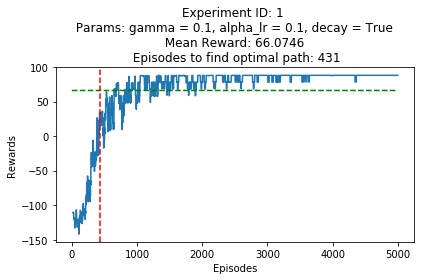

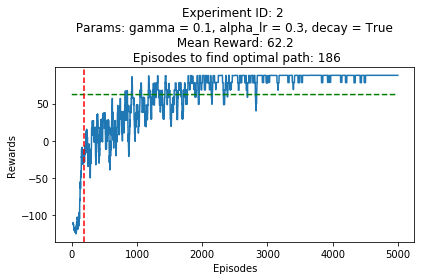

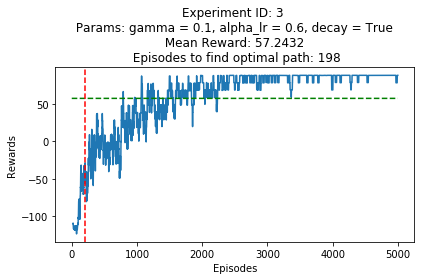

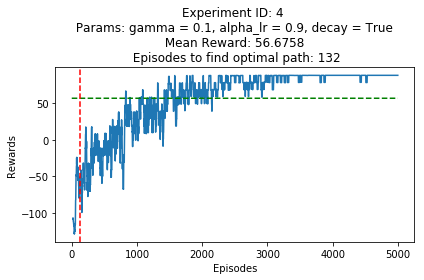

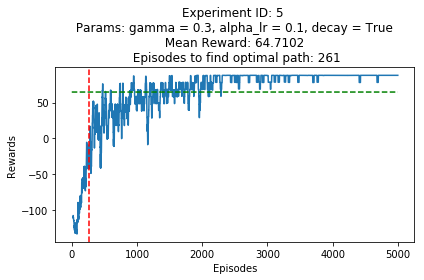

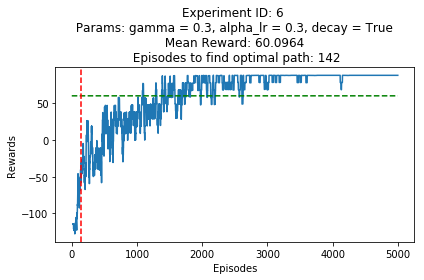

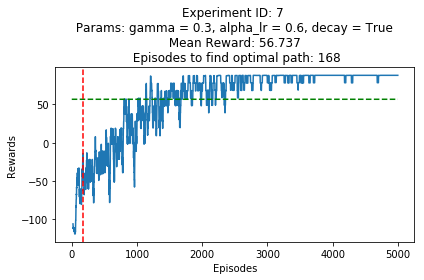

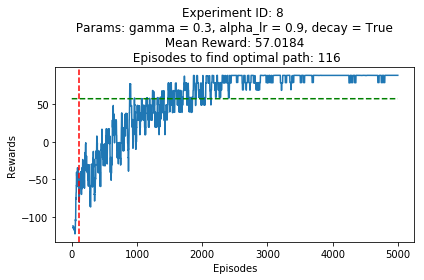

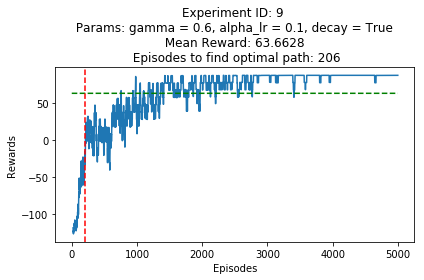

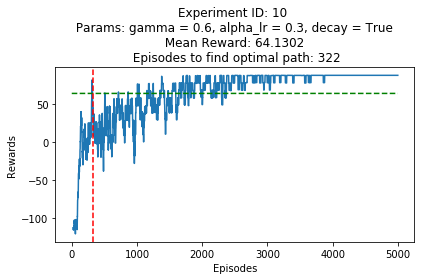

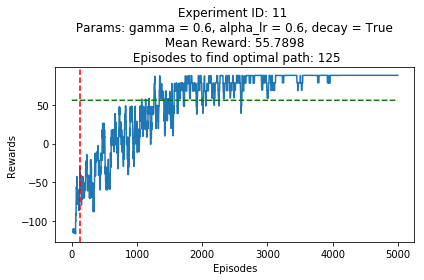

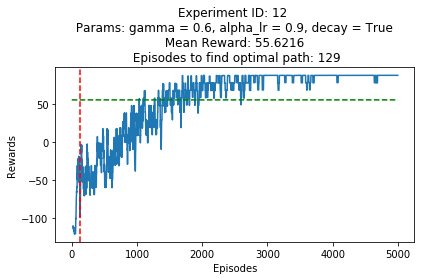

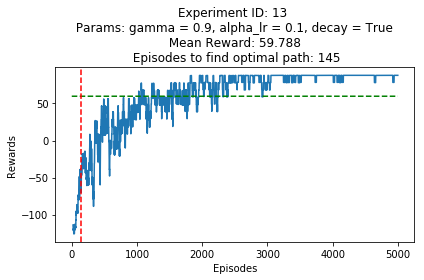

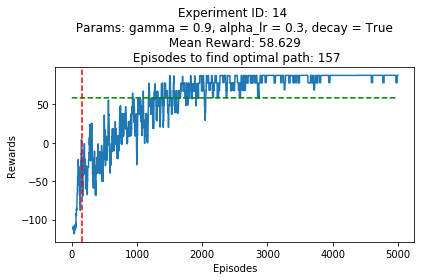

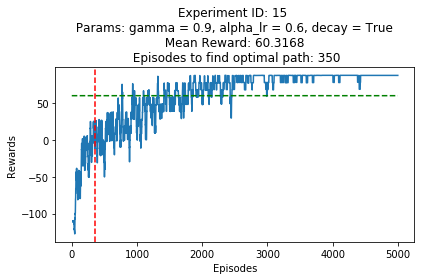

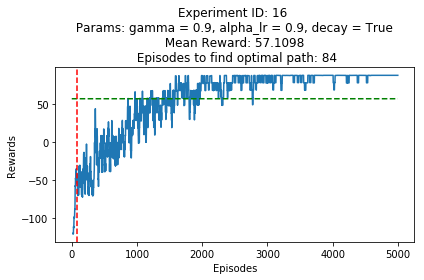

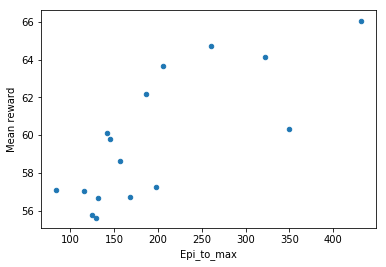

In [195]:
#gamma_param = [0.05,0.5,0.1,0.3,0.5,0.8,1]
#alpha_lr_param = [0.05,0.5,0.1,0.3,0.5,0.8,1] 

#gamma_param = [0.1,0.3, 0.6, 0.9]
#alpha_lr_param = [0.1,0.3, 0.6, 0.9]

#gamma_param = [0.1]
#alpha_lr_param = [0.1]

def run_Q (gamma_param = [0.1,0.3, 0.6, 0.9], 
           alpha_lr_param = [0.1,0.3, 0.6, 0.9], 
           decay_param = [True], 
           verbose = True, 
           plot_figures = True,
           parse_results = True
          ):
    
    max_experiments = len(gamma_param)*len(alpha_lr_param)*len(decay_param) 
    results_list = []
    experiment_id = 1

    #add in epsilon?
    for i in gamma_param:
        for j in alpha_lr_param: 
            for k in decay_param: 
                q_learning_rewards, Q, episodes_to_max = zip(*[q_learning(cliff, decay = k, gamma= i, render=False,
                                                         alpha_lr= j ) for _ in range(1)])
                avg_rewards = np.mean(q_learning_rewards, axis=0)
                mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)
                #max_reward = np.max(q_learning_rewards, axis=0)

                if plot_figures:
                    fig, ax = plt.subplots()
                    ax.set_xlabel('Episodes')
                    ax.set_ylabel('Rewards')
                    ax.set_title('Experiment ID: {} \n Params: gamma = {}, alpha_lr = {}, decay = {} \n Mean Reward: {} \n Episodes to find optimal path: {}'.format(experiment_id, i, j, k, mean_reward[0],"Not found" if min(episodes_to_max) == 99999 else min(episodes_to_max) ))

                    rolling_avg_rewards = pd.Series(avg_rewards).rolling(20, min_periods=20).mean()


                    ax.plot(rolling_avg_rewards)

                    ax.plot(mean_reward, 'g--')

                    if min(episodes_to_max) != 99999: 
                        ax.axvline(x=min(episodes_to_max), color='r', linestyle='--')

                    plt.tight_layout()
                    fig.savefig('{}_results_q.png'.format(experiment_id), pad_inches=1)

                results = {'Experiment_ID': experiment_id,
                           'gamma': i,
                           'alpha_lr': j,
                           'decay': k,
                           'Mean reward': mean_reward[0],
                           'Epi_to_max' : min(episodes_to_max)
                          }

                results_list.append(results)

                if verbose: 
                    print ('Experiment {} of {} complete'.format(experiment_id, max_experiments))
                experiment_id += 1
            
    if parse_results: 
        parsed_results_df = parse_results_list(results_list)
        return parsed_results_df

    else: 
        return results_list
    
Q_results = run_Q()


## SA_Q_LEARNING: grid search

Episode: 0 completed


/Users/williamneedham/.virtualenvs/cityCV/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


Found optimal path after only: 612 episodes
Episode: 1000 completed
Episode: 2000 completed
Episode: 3000 completed
Episode: 4000 completed
Experiment 1 of 16 complete
Top 5 results, by episodes to find optimal path: 
    Epi_to_max  Experiment_ID  Mean reward  alpha_lr  gamma
0         612              1      55.6258       0.1    0.1

 
 Top 5 results, by mean reward over 5000 episodes: 
    Epi_to_max  Experiment_ID  Mean reward  alpha_lr  gamma
0         612              1      55.6258       0.1    0.1


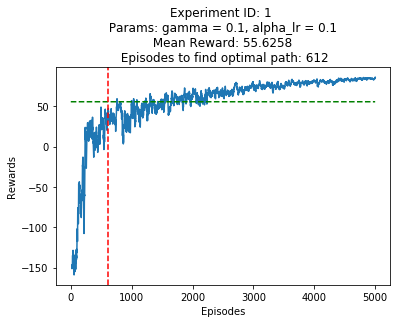

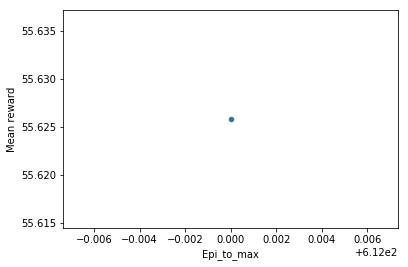

In [197]:
def run_SA_Q (gamma_param = [0.1,0.3, 0.6, 0.9], 
           alpha_lr_param = [0.1,0.3, 0.6, 0.9], 
           decay_param = [True], 
           verbose = True, 
           plot_figures = True,
           parse_results = True
          ):
    
    max_experiments = len(gamma_param)*len(alpha_lr_param)
    results_list = []
    experiment_id = 1

    for i in gamma_param:
        for j in alpha_lr_param: 
            rewards_list, Q_matrix, episodes_to_max = zip(*[sa_q_learning(cliff, num_episodes=5000, render=False, epsilon = 0.9, 
                                    epsilon_threshold = 0.8, alpha_lr =j, gamma=i) for _ in range(1)])
            avg_rewards = np.mean(rewards_list, axis=0)
            mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)
            #max_reward = np.max(q_learning_rewards, axis=0)

            if plot_figures:
                fig, ax = plt.subplots()
                ax.set_xlabel('Episodes')
                ax.set_ylabel('Rewards')
                ax.set_title('Experiment ID: {} \n Params: gamma = {}, alpha_lr = {} \n Mean Reward: {} \n Episodes to find optimal path: {}'.format(experiment_id, i, j, mean_reward[0],"Not found" if min(episodes_to_max) == 99999 else min(episodes_to_max) ))

                rolling_avg_rewards = pd.Series(avg_rewards).rolling(20, min_periods=20).mean()


                ax.plot(rolling_avg_rewards)

                ax.plot(mean_reward, 'g--')

                if min(episodes_to_max) != 99999: 
                    ax.axvline(x=episodes_to_max, color='r', linestyle='--')

                plt.subplots_adjust(top=0.88)

                fig.savefig('{}_results.jpg'.format(experiment_id), pad_inches=1)

            results = {'Experiment_ID': experiment_id,
                       'gamma': i,
                       'alpha_lr': j,
                       'Mean reward': mean_reward[0],
                       'Epi_to_max' : min(episodes_to_max)
                      }

            results_list.append(results)

            if verbose: 
                print ('Experiment {} of {} complete'.format(experiment_id, max_experiments))
            experiment_id += 1

            if parse_results: 
                parsed_results_df = parse_results_list(results_list)
                return parsed_results_df

            else: 
                return results_list

SA_Q_results = run_SA_Q()

## run bqsa

In [ ]:
def run_bqsa (gamma_param = [0.1,0.3, 0.6, 0.9], 
           alpha_lr_param = [0.1,0.3, 0.6, 0.9], 
           decay_param = [True], 
           verbose = True, 
           plot_figures = False,
           parse_results = True,
           render1 = False
              
          ):
    
    max_experiments = len(gamma_param)*len(alpha_lr_param)
    results_list = []
    experiment_id = 1

    for i in gamma_param:
        for j in alpha_lr_param: 
            rewards_list, Q_matrix, episodes_to_max, M = zip(*[bqsa_learning(cliff, alpha_lr =j, gamma=i) for _ in range(1)])
            avg_rewards = np.mean(rewards_list, axis=0)
            mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)
            #max_reward = np.max(q_learning_rewards, axis=0)

            if plot_figures:
                fig, ax = plt.subplots()
                ax.set_xlabel('Episodes')
                ax.set_ylabel('Rewards')
                ax.set_title('Experiment ID: {} \n Params: gamma = {}, alpha_lr = {} \n Mean Reward: {} \n Episodes to find optimal path: {}'.format(experiment_id, i, j, mean_reward[0],"Not found" if min(episodes_to_max) == 99999 else min(episodes_to_max) ))

                rolling_avg_rewards = pd.Series(avg_rewards).rolling(20, min_periods=20).mean()


                ax.plot(rolling_avg_rewards)

                ax.plot(mean_reward, 'g--')

                if min(episodes_to_max) != 99999: 
                    ax.axvline(x=episodes_to_max, color='r', linestyle='--')

                plt.subplots_adjust(top=0.88)

                fig.savefig('{}_results_bqsa.jpg'.format(experiment_id), pad_inches=1)

            results = {'Experiment_ID': experiment_id,
                       'gamma': i,
                       'alpha_lr': j,
                       'Mean reward': mean_reward[0],
                       'Epi_to_max' : min(episodes_to_max)
                      }

            results_list.append(results)

            if verbose: 
                print ('Experiment {} of {} complete'.format(experiment_id, max_experiments))
            experiment_id += 1

    if parse_results: 
        parsed_results_df = parse_results_list(results_list)
        return parsed_results_df

    else: 
        return results_list

bqsa_results = run_bqsa()

Episode: 0 completed
Episode: 1000 completed
Episode: 2000 completed
Episode: 3000 completed
Episode: 4000 completed
Experiment 1 of 16 complete
Episode: 0 completed
Episode: 1000 completed
Episode: 2000 completed
Episode: 3000 completed
Episode: 4000 completed
Experiment 2 of 16 complete
Episode: 0 completed


# Extension: SARSA 

## Extensible re-implementation of same Q-learning same approach in Tensorflow


#### Initialise network structure

In [45]:
import torch

In [ ]:
gamma_param = [0.8]
alpha_lr_param = [0.1,0.3] 
decay_param = [True]
for i in gamma_param:
    for j in alpha_lr_param: 
        for k in decay_param: 
            print(i)
            print(j)
            print(k)